# Imports and Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/Okra project data/"

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer


import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk import word_tokenize, pos_tag

from gensim import matutils, models, corpora
from gensim.parsing.preprocessing import remove_stopwords
import scipy.sparse

!pip install spacy_langdetect
from spacy_langdetect import LanguageDetector
import spacy

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # needed for a gensim library function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


Loading the data is pretty straightforward as it is already scraped and packaged in a json.
Let's first have a look at how it is structured:

In [2]:
with open(root+'train_reviews.json') as train_file:
    jsondata = json.load(train_file)

display(jsondata[:2])
initial_length = len(jsondata)
print("\n number of reviews: ", initial_length)

[{'date': '2015-10-10T14:32:51.000+00:00',
  'stars': 'star-rating star-rating-1 star-rating--medium',
  'text': "Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.",
  'title': 'Bad customer service. Staff are very impolite and rude',
  'url': 'https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4'},
 {'date': '2015-09-22T17:04:56.000+00:00',
  'stars': 'star-rating star-rating-1 star-rating--medium',
  'text': "I phoned National rail to find out why several trains had been cancelled to Brighton, none of the advisers spoke English and told me to check the website. Turns out they cancelled a load of trains just because the train guard didn't show up, meaning many people were stranded at Southampton Central, including myself who had a plane flight to catch early the next morning. Southampton Central is easily the worse run station ever, th


 number of reviews:  2021


It seems to be a well-formed json: an array of dictionaries with each dictionary representing a review; we have 2021 reviews, which matches what the assignment document said ("about 2000"). Since there is no issue here, we can load it in pandas for easier handling and optimized operations. 

*On a side note: Pandas uses numpy and cython under the hood, which in turn use C and thus circumvent python's GIL, allowing for parallelization. We don't necessarily need it here, as this data set is quite small, but it can be nice nonetheless.*

In [3]:
data = pd.DataFrame.from_dict(jsondata)
display(data.head())
print("length of data: ", len(data))

,date,title,text,url,stars
0,2015-10-10T14:32:51.000+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22T17:04:56.000+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13T23:37:05.000+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13T12:26:52.000+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28T15:00:36.000+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium


length of data:  2021


# Preprocessing and Exploratory Data Analysis

## Preprocessing

There is some cleaning up to do. 

First of all, the url is useless, as it only points to the page the review was scraped from. That would tell us two things: roughly when it was posted and what other reviews the poster saw on that page while posting. The former is better represented by the "date" anyway,and taking the latter into account is beyond the scope of this project. 

Hence we can drop it.

In [4]:
if 'url' in data.columns:
  del data['url']

Next, let's check that everything is the data type it should be.

In [5]:
print("data types")
print("\ndate: ", type(data['date'][0]))
print("title: ", type(data['title'][0]))
print("text: ", type(data['text'][0]))
print("stars: ", type(data['stars'][0]))

data types

date:  <class 'str'>
title:  <class 'str'>
text:  <class 'str'>
stars:  <class 'str'>


title and text are ok, they should be string. Date should be datetime and stars needs to be changed as well.

In [6]:
data['date'] = pd.to_datetime(data['date'])
print("date new data type: ", type(data['date'][0]))
data['date'].head()

date new data type:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


0   2015-10-10 14:32:51+00:00
1   2015-09-22 17:04:56+00:00
2   2015-03-13 23:37:05+00:00
3   2015-01-13 12:26:52+00:00
4   2011-05-28 15:00:36+00:00
Name: date, dtype: datetime64[ns, UTC]

Looks good. 

Now onto stars: this is a bit more problematic.It contains the obviously important information of how many stars were given in the review, but also the cryptic "star-rating--medium" indication. A quick look at the review website does not give a clear indication for what it might be. Let's look into that first to see if we can safely ignore it.

In [7]:
if isinstance(data['stars'][0] , str):
  data['star-rating'] = data['stars'].str.extract(r'--(\w*)')
  display(data['star-rating'].head())
  print("\nnumber of data points where star rating is medium: ", len(data[data['star-rating']=='medium']))

  if 'star-rating' in data.columns:
    if len(data[data['star-rating']=='medium']) == len(data):
      del data['star-rating']


  data['stars'] = data['stars'].str.extract(r'star-rating-([012345])')
  data['stars'] = pd.to_numeric(data['stars'])

0    medium
1    medium
2    medium
3    medium
4    medium
Name: star-rating, dtype: object


number of data points where star rating is medium:  2021


In [8]:
display(data.head())
print("data types")
print("\ndate: ", type(data['date'][0]))
print("title: ", type(data['title'][0]))
print("text: ", type(data['text'][0]))
print("stars: ", type(data['stars'][0]))

,date,title,text,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,1
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,1
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,1
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,4
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,4


data types

date:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
title:  <class 'str'>
text:  <class 'str'>
stars:  <class 'numpy.int64'>


As it should be.

A last couple of safety checks before we continue:

In [9]:
print('Null and NaN values in data set: ', data.isnull().values.any())
print('Did we lose any values along the way?', (len(data)!=2021))

Null and NaN values in data set:  False
Did we lose any values along the way? False


## Text Cleaning

We'll do a rough cleaning of the review text here.

Admittedly, I did not know about the spacy library before this assignment, but it seems to have some pretty [cool functionality](https://pypi.org/project/spacy-langdetect/) that I want to test out. I will use it to check for and remove non-english reviews.

But first, some standard operations (some of which taken from stack overflow, no reason why I shouldn't make life easy for myself):

In [10]:
# Make strings lowercase
data['title'] = data['title'].apply(lambda x: str.lower(x))
data['text'] = data['text'].apply(lambda x: str.lower(x))

# Spellcheck the reviews (not feasibly doable on my machine)
#data['text'][:3].apply(lambda x: str(TextBlob(x).correct()))

# Remove special characters (leaving dots and apostrophes in)
spec_chars = ["!",'"',"#","%","&","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    data['title'] = data['title'].str.replace(char, ' ')
    data['text'] = data['text'].str.replace(char, ' ')

data['text'] = data['text'].str.split().str.join(" ")

# replace numbers with money
data['text'] = data['text'].replace(to_replace=r'\d+\xa3', value='money', regex=True)
data['text'] = data['text'].replace(to_replace=r'\xa3\d+', value='money', regex=True)

# replace numbers with hour
data['text'] = data['text'].replace(to_replace=r'\d+pm', value='hour', regex=True)
data['text'] = data['text'].replace(to_replace=r'\d+am', value='hour', regex=True)

# split number and text
data['text'] = data['text'].apply(lambda x: re.sub(r"(\d+(\.\d+)?)",r" \1 ", x).strip())

# replace numbers (except year numbers) with number
data['text'] = data['text'].replace(to_replace=r'\b(?!(\D\S*|[12][0-9]{3})\b)\S+\b', value='number', regex=True)

# remove stopwords
stop = set(stopwords.words('english'))
data['text'].apply(lambda x: remove_stopwords(x))

# lemmatize to normalize various forms of the same word, like (train/trains -> train or buying/bought -> buy)
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

data['text'] = data['text'].apply(lemmatize_text)

data['text']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


0       Used national rail twice and on both occasion ...
1       I phoned National rail to find out why several...
2       I travel from Brokenhast to southampton centra...
3       Saved about money on a single trip using Natio...
4       I always use the national rail enquiry site wh...
                              ...                        
2016    Late cancelled signal failure too much rain to...
2017    Trains are constantly delayed or cancelled I a...
2018    On a yearly basis we take a group of Preschool...
2019    I travel by them every day I like their newish...
2020                           To start with the positive
Name: text, Length: 2021, dtype: object

The reason why I didn't add explicit tags for things I removed, like numbers and hours, is that sklearn's CoutVectorizer will ignore those. Now we still have some numbers in there that are 4 digits and not actual years, but their incidence is minimal, so I won't worry about it affecting the model too much.


In [11]:
nlp = spacy.load("en")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

def print_non_english_data(text: pd.Series):
  count = 0
  for doc in nlp.pipe(text.values):
    lang = doc._.language

    # If the language is not english
    if lang['language'] != 'en':
      count += 1
      print("score: ", round(lang['score'], 2), " | language: ", lang['language'], " | text: ", doc)

    # If spacy can't confidently tell if it's english
    if ((lang['language'] == 'en') & (lang['score'] < 0.7)):
      count += 1
      print("score: ", round(lang['score'], 2), " | language: ", lang['language'], " | text: ", doc)

  print("Number of possibly non-english reviews found by spacy: ", count, " in percent: ", round(count/len(data)*100, 2), "%")

#### printing non-english text:

In [12]:
print_non_english_data(data['text'])

score:  0.86  | language:  de  | text:  number June number
score:  0.57  | language:  en  | text:  Extremely rude and unhelpful staff
score:  0.71  | language:  de  | text:  number June number
score:  0.57  | language:  en  | text:  Extremely rude and unhelpful staff
score:  0.71  | language:  de  | text:  number June number
score:  0.43  | language:  en  | text:  number June number
score:  0.71  | language:  de  | text:  number June number
score:  0.57  | language:  en  | text:  Extremely rude and unhelpful staff
score:  0.71  | language:  de  | text:  number June number
score:  0.57  | language:  ro  | text:  Extremely rude and unhelpful staff
score:  0.71  | language:  ro  | text:  Extremely rude and unhelpful staff
score:  0.72  | language:  de  | text:  number June number
score:  0.57  | language:  de  | text:  number June number
score:  0.43  | language:  de  | text:  number June number
score:  0.71  | language:  ro  | text:  Extremely rude and unhelpful staff
score:  0.71  | lan

#### printing non-english titles:

In [13]:
print_non_english_data(data['title'])

score:  0.71  | language:  cy  | text:  Awful staff
score:  1.0  | language:  af  | text:  Very good
score:  0.85  | language:  af  | text:  Worst in europe
score:  0.73  | language:  nl  | text:  Poor website design
score:  1.0  | language:  da  | text:  Todmorden to Huddersfield
score:  1.0  | language:  et  | text:  Useless
score:  1.0  | language:  so  | text:  Bad bad bad 
score:  1.0  | language:  fr  | text:  No complaints
score:  1.0  | language:  af  | text:  Not Good
score:  0.57  | language:  en  | text:  No trust     
score:  1.0  | language:  ca  | text:  Excellent Service
score:  0.86  | language:  nl  | text:  Caledonian Sleeper
score:  1.0  | language:  af  | text:  Not Good
score:  1.0  | language:  af  | text:  Not Good
score:  1.0  | language:  af  | text:  Not Good
score:  1.0  | language:  af  | text:  Not Good
score:  1.0  | language:  af  | text:  Not Good
score:  0.57  | language:  en  | text:  No trust     
score:  0.57  | language:  en  | text:  No trust     


#### looking at specific examples:

In [49]:
data[data['text'] == 'not good']

,date,title,text,stars


In [50]:
data[data['text'] == 'No trust']

,date,title,text,stars


Text operations unfortunately always take long (and looping in python is a sin), but luckily we have only a small data set. It is clear that spacy's accuracy is not always what we wish for, especially for short strings. It is therefore clear we can only hope to use it on text and not the title.

We found another porblem, however>: repeated reviews. These need to be removed, otherwise they will skew the model. Again, we will only remove repeated text. Titles might repeat for otherwise unique reviews; if the title between two non-unique reviews overlaps, removing repeated text will take care of that.

#### removing duplicates and looking at the result:

In [17]:
data_len = len(data)
data = data.drop_duplicates(subset=['text'])#
print("length before: ", data_len, "length after: ", len(data))
print("removed duplicates: ", data_len-len(data), " in percent: ", round((data_len-len(data))/data_len*100, 2), "%")

length before:  2021 length after:  1437
removed duplicates:  584  in percent:  28.9 %


Quite a lot of duplicates, unfortunately. 

In [18]:
print_non_english_data(data['text'])

score:  0.71  | language:  de  | text:  number June number
score:  0.57  | language:  en  | text:  Extremely rude and unhelpful staff
score:  0.86  | language:  sv  | text:  number number number
score:  1.0  | language:  de  | text:  RIP OFF
score:  0.57  | language:  it  | text:  Poor attitude
score:  1.0  | language:  de  | text:  VERY UNHAPPY
score:  0.71  | language:  ro  | text:  Dreadful
score:  0.57  | language:  fi  | text:  Hello
score:  0.43  | language:  en  | text:  Virgin train customer service are amazing
score:  1.0  | language:  fr  | text:  Mieux que le train français
score:  1.0  | language:  ro  | text:  Dreadful company
score:  0.57  | language:  en  | text:  still smell of poo
score:  0.86  | language:  da  | text:  Rude staff from beginning to end
score:  0.57  | language:  ro  | text:  Genuine error or racist service
score:  0.57  | language:  af  | text:  Good afternoon
score:  1.0  | language:  no  | text:  getting better
score:  1.0  | language:  cy  | text:  

Very small set of outliers suggested by spacy remaining. Only one of these is actually non-english and we can remove it manually.

In [19]:
data = data[data['text'] != 'Mieux que les trains français']

In [20]:
print("We are left with ", len(data), " data points. This is a reduction of ", 
      round((initial_length-len(data))/initial_length*100, 2), 
      "% from the original ", initial_length, " size of the dataset.")

We are left with  1437  data points. This is a reduction of  28.9 % from the original  2021  size of the dataset.


## General Overview of Ratings

Now let's look at some descriptive statistics and some general overview of this data set:

Average review score:  1.56 



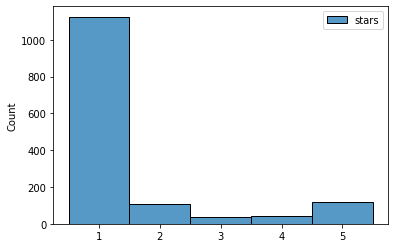

In [21]:
# Find average star rating
print('Average review score: ', round(np.mean(data['stars']), 2), '\n')

# Plot histogram of star ratings
sns.histplot(data, discrete=True)

stars                 
     count      mean median
date                       
2011     2  4.000000      4
2015    68  1.911765      1
2016   286  1.611888      1
2017   546  1.602564      1
2018   535  1.433645      1

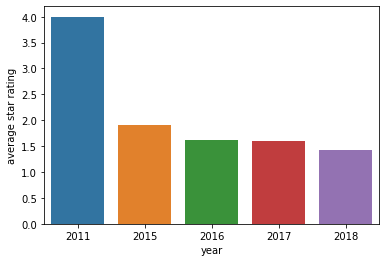

In [22]:
# Group data by year and compute yearly averages (text columns are ignored)
data_by_year = data.groupby(data.date.dt.year).agg(['count', 'mean', 'median'])
display(data_by_year)
ax = sns.barplot(x=data_by_year['stars'].unstack()['mean'].index, y=data_by_year['stars'].unstack()['mean'])
ax.set(xlabel='year', ylabel='average star rating')
plt.show()

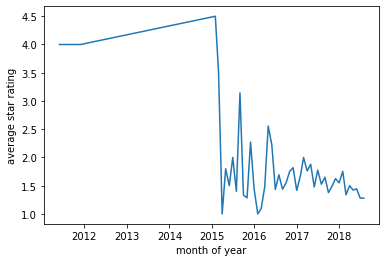

In [23]:
# Group data by data and plot line diagram
data_by_year = data.set_index('date').groupby(pd.Grouper(freq="M")).agg(['count', 'mean', 'median'])
ax = sns.lineplot(x=data_by_year['stars'].unstack()['mean'].index, y=data_by_year['stars'].unstack()['mean'])
ax.set(xlabel='month of year', ylabel='average star rating')
plt.show()

There are a few interesting observations to make here.

Firstly, there the data for 2011 can be seen as an outlier as there are only two 4 star reviews and no data between 2011 and 2015. Those two data points will therefore be removed.


In [24]:
# removing outliers from 2011

print("for fun, the first entry: (maybe a test review by the dev team?)")
print("\"I always use the national rail enquiry site when planning a rail journey. ")
print('The site allows you to find the quickest route and the cheapest fare. It also has up to date information on travel disruptions.\"')

if len(data[data['date'].dt.year == 2011]) != 0:
  display(data[data['date'].dt.year == 2011])
  data = data[data['date'].dt.year != 2011]
  print("length after removing: ", len(data))

for fun, the first entry: (maybe a test review by the dev team?)
"I always use the national rail enquiry site when planning a rail journey. 
The site allows you to find the quickest route and the cheapest fare. It also has up to date information on travel disruptions."


,date,title,text,stars
4,2011-05-28 15:00:36+00:00,Check it out,I always use the national rail enquiry site wh...,4
1950,2011-11-20 20:43:09+00:00,Reasonable prices good service,First class is very spacious free wireless int...,4


length after removing:  1435


Furthermore, the amount of reviews is increasing over time.

We also have overwhelmingly more negative reviews than positive, meaning that our data set is balanced. This has implications for model choice and what we can do with it.

# Model

## Model Ideas and Scope



**Assignment**

The assignment states that the train schedules "*have recently been changed*" and asks to see if and how the discussion shifted after that point in time. Knowing when this schedule change took place (and hence where to split the data) is crucial to do a "before versus after" topic analysis.

This is where domain knowledge could come in handy. Trying to find out from news reports when this change in schedules happened didn't prove very fruitful. 
The newest data point being 2018, leads me to conclude that this assignment might be somewhat older.

**Approach**

I first thought I could do a supervised sentiment analysis using the stars as labels and find out when the sentiment shifted (and thus hopefully, when the schedule changed). There are two reasons that won't work, however:  

1.   Sentiment, measured in stars, has a clear downward trend.
2.   The data set is highly skewed towards negative reviews. 1 star reviews make up almost 80% of the whole dataset. Many classifiers work badly with skewed data, as predicting one class (in this case negative sentiment) has a wildly different hit rate, contributing to classifier bias. Taking an equal sample would ameliorate this, but it would result in a very small training set for this data set.

Another option would be matching reviews to pre-defined (a priori) categories. If the rail company wanted to know, for exampe, which reviews are about delays as opposed to hygiene, a supervised topic classification would be the way to go. For this, however, I lack both domain knowledge/indication of common topics and also the time to hand-label a training set.

Taking into account the above mentioned constraints, I will go for a simple unsupervised clustering approach and see if that can properly model topics.



## Topic Modelling

For this, I decided to go with LDA (Latent Dirichelet Allocation, not to be confused with Linear Discriminant Analysis, which is often used in regression). LDA is probabilistic and is roughly the bayesian equivalent of pLSA (Latent Semantic Analysis).

First we need a term-document matrix, which will contain the frequency with which terms (words) appears in each document (in our case: each review). Then we'll make a corpus out of that and feed it to the LDA model. 

~~A point could be made about the need of stop word removal. While topic modelling is less reliant on the semantic information carried by stop words, I decided to not explicitly remove them (CoutVectorizer removes some).~~ <- *Now removed stopwords because model performs badly*

In [25]:
def prepare_corpus_and_id2word(text: pd.DataFrame):
  # Building a document-term matrix

  cv = CountVectorizer()
  data_cv = cv.fit_transform(text)
  data_cv_df = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

  tdm = data_cv_df.transpose()

  # creating a corpus out of a sparse matrix

  sparse_counts = scipy.sparse.csr_matrix(tdm)
  corpus = matutils.Sparse2Corpus(sparse_counts)

  # dictionary of terms for LDA. This maps each word to their unique integer ID
  id2word = dict((v, k) for k, v in cv.vocabulary_.items())
  word2id = dict((k, v) for k, v in cv.vocabulary_.items())
  d = corpora.Dictionary()
  d.id2token = id2word
  d.token2id = word2id

  return corpus, d

Now we only need to select the number of topics people might be broadly speaking about. It is up to us to set this parameter and there is, unfortunately, no 100% objective way to set it. Likewise, the goodness of this (unsupervised) model can only be validated via our "makes-sense" intuition. I will therefore try various settings.

In [26]:
corpus, term_dict = prepare_corpus_and_id2word(data['text'])
lda = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.042*"the" + 0.041*"to" + 0.029*"and" + 0.018*"number" + 0.016*"of" + 0.014*"for" + 0.013*"train" + 0.012*"in" + 0.012*"is" + 0.011*"on"'),
 (1,
  '0.049*"the" + 0.039*"to" + 0.029*"and" + 0.022*"wa" + 0.020*"train" + 0.019*"number" + 0.017*"on" + 0.012*"of" + 0.011*"we" + 0.011*"it"'),
 (2,
  '0.031*"to" + 0.028*"the" + 0.020*"and" + 0.017*"it" + 0.013*"train" + 0.012*"is" + 0.012*"they" + 0.011*"for" + 0.010*"in" + 0.010*"service"')]

In [27]:
lda = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=5, passes=10)
lda.print_topics()

[(0,
  '0.038*"the" + 0.026*"to" + 0.020*"number" + 0.018*"is" + 0.016*"and" + 0.014*"for" + 0.010*"it" + 0.010*"of" + 0.010*"on" + 0.008*"in"'),
 (1,
  '0.044*"the" + 0.036*"to" + 0.031*"and" + 0.019*"number" + 0.018*"train" + 0.016*"on" + 0.015*"for" + 0.013*"of" + 0.011*"it" + 0.011*"they"'),
 (2,
  '0.007*"the" + 0.007*"service" + 0.007*"number" + 0.006*"at" + 0.005*"they" + 0.005*"train" + 0.005*"and" + 0.005*"we" + 0.005*"birmingham" + 0.005*"virgin"'),
 (3,
  '0.040*"the" + 0.027*"to" + 0.022*"and" + 0.020*"of" + 0.018*"train" + 0.016*"is" + 0.015*"in" + 0.015*"number" + 0.012*"on" + 0.011*"are"'),
 (4,
  '0.052*"to" + 0.045*"the" + 0.029*"and" + 0.018*"wa" + 0.015*"ticket" + 0.015*"number" + 0.014*"train" + 0.013*"my" + 0.012*"of" + 0.012*"for"')]

In [28]:
lda = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=10, passes=10)
lda.print_topics()

[(0,
  '0.005*"took" + 0.005*"south" + 0.004*"getting" + 0.004*"unfortunate" + 0.003*"money" + 0.003*"and" + 0.003*"at" + 0.003*"existence" + 0.003*"garbage" + 0.003*"dept"'),
 (1,
  '0.028*"to" + 0.024*"the" + 0.018*"and" + 0.016*"in" + 0.015*"train" + 0.013*"it" + 0.011*"on" + 0.011*"service" + 0.010*"they" + 0.008*"you"'),
 (2,
  '0.021*"no" + 0.013*"service" + 0.009*"star" + 0.009*"late" + 0.007*"or" + 0.006*"there" + 0.006*"dreadful" + 0.005*"just" + 0.005*"not" + 0.005*"is"'),
 (3,
  '0.059*"the" + 0.047*"to" + 0.024*"number" + 0.022*"and" + 0.017*"train" + 0.015*"wa" + 0.014*"for" + 0.013*"on" + 0.013*"we" + 0.012*"in"'),
 (4,
  '0.038*"and" + 0.035*"the" + 0.034*"to" + 0.015*"wa" + 0.013*"on" + 0.013*"of" + 0.013*"they" + 0.012*"it" + 0.011*"in" + 0.011*"is"'),
 (5,
  '0.047*"to" + 0.037*"the" + 0.034*"and" + 0.022*"number" + 0.018*"train" + 0.018*"my" + 0.017*"wa" + 0.015*"ticket" + 0.014*"of" + 0.014*"on"'),
 (6,
  '0.009*"company" + 0.008*"rail" + 0.007*"problem" + 0.006*"th

(*At this stage I will mention that my intuition was wrong. Apparently stopwords do matter (I argued against removing them), as the categories in the first run seemed to be built mostly out of them, regardless of number of topics. I therefore went back to my pre-processing step and added stop-word removal*) ex. : ('0.052*"the" + 0.040*"to" + 0.029*"and" + 0.026*"train" + 0.021*"they" + 0.021*"number" + 0.019*"on" + 0.016*"is" + 0.016*"you" + 0.014*"are"')

I am still unhappy with the results, as there are several prepositions and conjunctions in the topics. Therefore, I will try to only use only certain types of words.

In [29]:
test = "The train arrived late at our lovely station and continues to be dirty. Ouch!"
pos_tag(word_tokenize(test))

[('The', 'DT'),
 ('train', 'NN'),
 ('arrived', 'VBD'),
 ('late', 'RB'),
 ('at', 'IN'),
 ('our', 'PRP$'),
 ('lovely', 'JJ'),
 ('station', 'NN'),
 ('and', 'CC'),
 ('continues', 'VBZ'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('dirty', 'JJ'),
 ('.', '.'),
 ('Ouch', 'JJ'),
 ('!', '.')]

pos_tag uses all sorts of useful tags. I think I will keep nouns, adjectives and adverbs. Verbs would include very common forms of "to be" and "to have", so we'll skip those (perhaps only including gerunds might be an idea). Interjections are tagged as nouns/adjectives so we will keep those (we really need all the expletatives for these reveiws, they play a major role).

In [30]:
# Tag nouns, adverbs and adjectives remove the rest.
def filter_word_types(review):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokens = word_tokenize(review)
    nouns_adj_adv = [word for (word, pos) in pos_tag(tokens) if ((pos[:2] == 'NN') | (pos[:2] == 'JJ') | (pos[:2] == 'RB'))] 
    return ' '.join(nouns_adj_adv)

filter_word_types(test)

'train late lovely station dirty Ouch'

In [31]:
data['text'] = data['text'].apply(filter_word_types)
data['text']

0       national rail twice occasion staff unpleasant ...
1       National rail several train Brighton none advi...
2       Brokenhast central ticket train n't time South...
3       money single trip NationalRail specific train ...
5       website always problem journey head back main ...
                              ...                        
2016    Late signal failure too much rain too sunny re...
2017    Trains constantly not sure even timetable only...
2018    yearly basis group Preschool child train ride ...
2019    day newish train always kept clean very often ...
2020                                             positive
Name: text, Length: 1435, dtype: object

OK, now let's try the model again:

In [32]:
corpus, term_dict = prepare_corpus_and_id2word(data['text'])

In [51]:
lda3 = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=3, passes=10)
lda3.print_topics()

[(0,
  '0.042*"train" + 0.027*"number" + 0.019*"service" + 0.014*"not" + 0.011*"time" + 0.009*"company" + 0.008*"southern" + 0.008*"late" + 0.007*"day" + 0.007*"just"'),
 (1,
  '0.036*"number" + 0.030*"train" + 0.024*"ticket" + 0.020*"not" + 0.018*"service" + 0.014*"wa" + 0.013*"virgin" + 0.012*"customer" + 0.011*"class" + 0.010*"time"'),
 (2,
  '0.045*"number" + 0.027*"train" + 0.017*"ticket" + 0.016*"service" + 0.015*"not" + 0.012*"time" + 0.012*"hour" + 0.012*"virgin" + 0.011*"so" + 0.010*"journey"')]

Since both the pre-processing and the LDA model contain some randomization, I will pickle them for consistency. When I discuss the findings, I refer to this pickled version.

In [66]:
import pickle

def save_state(model, corpus, term_dict, add_to_name=''):
  model_name = 'lda3'+add_to_name+'.pkl'
  corpus_name = 'corpus'+add_to_name+'.pkl'
  term_dict_name = 'term_dict'+add_to_name+'.pkl'
  pickle.dump(model, open(model_name, 'wb'))
  pickle.dump(corpus, open(corpus_name, 'wb'))
  pickle.dump(term_dict, open(term_dict_name, 'wb'))

def load_state(add_to_name):
  model = pickle.load(open('lda3'+add_to_name+'.pkl', 'rb'))
  corpus = pickle.load(open('corpus'+add_to_name+'.pkl', 'rb'))
  term_dict = pickle.load(open('term_dict'+add_to_name+'.pkl', 'rb'))
  return model, corpus, term_dict


In [53]:
#save_state(lda3, corpus, term_dict)

In [34]:
lda5 = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=5, passes=10)
lda5.print_topics()

[(0,
  '0.011*"not" + 0.009*"customer" + 0.008*"service" + 0.007*"southern" + 0.006*"london" + 0.006*"eurostar" + 0.006*"point" + 0.006*"star" + 0.006*"day" + 0.005*"only"'),
 (1,
  '0.033*"train" + 0.032*"number" + 0.025*"service" + 0.018*"time" + 0.012*"not" + 0.010*"customer" + 0.010*"hour" + 0.010*"late" + 0.009*"company" + 0.009*"journey"'),
 (2,
  '0.040*"train" + 0.023*"service" + 0.022*"not" + 0.021*"virgin" + 0.019*"number" + 0.010*"wa" + 0.008*"class" + 0.008*"company" + 0.008*"ticket" + 0.007*"money"'),
 (3,
  '0.051*"train" + 0.034*"number" + 0.019*"not" + 0.016*"ticket" + 0.015*"wa" + 0.012*"staff" + 0.011*"so" + 0.010*"very" + 0.008*"journey" + 0.008*"london"'),
 (4,
  '0.054*"number" + 0.030*"ticket" + 0.020*"service" + 0.020*"train" + 0.016*"not" + 0.014*"time" + 0.013*"customer" + 0.012*"wa" + 0.011*"money" + 0.010*"virgin"')]

In [42]:
lda10 = models.LdaModel(corpus=corpus, id2word=term_dict, num_topics=10, passes=10)
lda10.print_topics()

[(0,
  '0.063*"number" + 0.062*"train" + 0.016*"not" + 0.014*"wa" + 0.014*"seat" + 0.013*"virgin" + 0.013*"ticket" + 0.012*"hour" + 0.012*"service" + 0.010*"journey"'),
 (1,
  '0.049*"train" + 0.027*"number" + 0.026*"service" + 0.013*"day" + 0.012*"not" + 0.011*"london" + 0.011*"so" + 0.009*"time" + 0.009*"seat" + 0.009*"hour"'),
 (2,
  '0.024*"train" + 0.019*"number" + 0.018*"time" + 0.014*"just" + 0.011*"not" + 0.009*"company" + 0.009*"service" + 0.008*"staff" + 0.007*"always" + 0.006*"very"'),
 (3,
  '0.032*"number" + 0.018*"time" + 0.014*"service" + 0.012*"ticket" + 0.012*"london" + 0.009*"year" + 0.008*"company" + 0.008*"day" + 0.007*"just" + 0.007*"seat"'),
 (4,
  '0.036*"service" + 0.025*"ticket" + 0.016*"not" + 0.016*"number" + 0.016*"time" + 0.015*"train" + 0.013*"customer" + 0.010*"company" + 0.009*"seat" + 0.009*"wa"'),
 (5,
  '0.056*"number" + 0.032*"ticket" + 0.026*"not" + 0.024*"money" + 0.018*"train" + 0.013*"customer" + 0.013*"class" + 0.012*"refund" + 0.012*"first" + 0

Better. Let's try to visualize them

In [44]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda10, corpus, term_dict)


In [45]:
pyLDAvis.display(lda_viz)

Trying to identify 10 topics is disproportionate (as expected), since many of those topics overlap. It seems that three or four topics would suffice.

## Reflections on Preliminary Results

In [56]:
# Loading model for consistency
model, corpus, term_dict = load_state()

In [57]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(model, corpus, term_dict)
pyLDAvis.display(lda_viz)

The most relevant terms in each of the topics identified by the model are generally not the most salient (i.e. the most uniquely topic-identifying). Unsurprisingly, "train", "service" and numbers are in the top most relevant terms for all three topics.

Top 3 most salient terms are:


1.   class
2.   southern
3.   virgin

Interestingly, two out of three indicate train operating companies, with a -as far as I am aware- infamously bad reputation. The services offered by Virgin were taken over by Avanti in 2019, about one year after the last data point.

The most salient term -class- probably refers to first class or second class. Looking over the data set, I noticed quite a few reviews mentioning class as relevant (some saying the service was bad despite class, others praising it instead).

As for the 3 topics, I think they could be summarized thusly:

1.   **Topic 1:** By looking at various relevance settings (lambda parameter of the visualization), terms like food, service, first class, sandwich, drink and staff pop out. I believe that this could be an indication for refreshment services being important to first class customers. Virgin was mentioned often.
2.   **Topic 2:** Delay, queue, time, Minute, journey are salient for this topic. But also student, fare, visa, gare (station in french). I think this topic relates more to the general experience with a train's main purpose: getting from A to B in a reasonable time. Again, Virgin is a salient term here.
3.   **Topic 3:** A lot of negative adjectives appear to be salient for this one: uncomfortable, late, worst, bad, overcrowded. It also mentiones various companies such as southern and thalys.





## Change Over Time

Analyzing the change over time is a tricky task, that takes some time and effort and would, franky, require a larger data set. 

As a proxy, I will pick the top three terms by saliency of my model and see how their frequency changed over time. This should give an indication on whether those topics remained relevant across the years. 

For this, I will group 2015, 2016 and 2017 data together and compare it to 2018 (assuming that the schedule change mentioned in the assignment happened sometime then). This also has the advantage of creating somewhat balanced data sets, since 2015 and 2016 have significantly fewer reviews than the two more recent years.

Splitting the data:

In [63]:
data_early = data[(data['date'].dt.year == 2015) |
                  (data['date'].dt.year == 2016) |
                  (data['date'].dt.year == 2017)]
data_late = data[data['date'].dt.year == 2018]

In [64]:
# Build two corpora
corpus_early, term_dict_early = prepare_corpus_and_id2word(data_early['text'])
corpus_late, term_dict_late = prepare_corpus_and_id2word(data_late['text'])

In [65]:
# Train two models
lda3_early = models.LdaModel(corpus=corpus_early, id2word=term_dict_early, num_topics=3, passes=10)
lda3_late = models.LdaModel(corpus=corpus_late, id2word=term_dict_late, num_topics=3, passes=10)

In [67]:
# Save the two models

save_state(lda3_early, corpus_early, term_dict_early, add_to_name="_early")
save_state(lda3_late, corpus_late, term_dict_late, add_to_name="_late")

In [69]:
# Load the two models (only needed if you haven't trained them or if you want to use mine)

model_early, corpus_early, term_dict_early = load_state(add_to_name="_early")
model_late, corpus_late, term_dict_late = load_state(add_to_name="_late")

[[0.87978142 0.51084082 0.9897541 ]
 [0.83157422 0.52786885 1.        ]
 [0.90293356 0.65487489 0.95823327]]


Text(0.5, 1.0, 'heatmap of topic similarity')

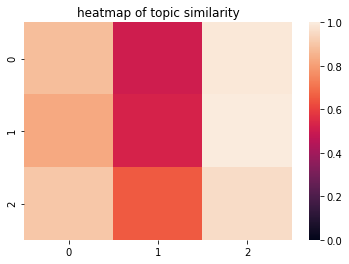

In [84]:
# Topic modelling difference
diff_matrix = model_early.diff(model_late, distance='jaccard')[0]
print(diff_matrix)
ax = sns.heatmap(diff_matrix, vmin=0, vmax=1)
ax.set_title("heatmap of topic similarity")

Note: title numbering do not necessarily coincide between models, nor do they coincide with the full model described above (before splitting off 2018 data). Since the columns have consistent distance scores, i.e. similarity metrics, we know that the two models modelled the topics very differently. If the pre-2018 and 2018 models had similar topics, scores/colors would be similar across diagonals, as opposed to columns.


Now let's look at our top 3 saliant terms:

In [135]:
lda_viz = gensimvis.prepare(model_early, corpus_early, term_dict_early)
pyLDAvis.display(lda_viz)

In [136]:
lda_viz = gensimvis.prepare(model_late, corpus_late, term_dict_late)
pyLDAvis.display(lda_viz)

The salient terms for topics are also significantly different. Class plays a major role both in 2018 and pre-2018 data, as "first" is also a salient term in early data.

Customer in 2018 data and eurostar in pre-2018 data, are not in each other's top 3, but are pretty relevant as they are still found in the top 10. Frequencies also significantly differ. Surprisingly, train is not mentioned as often in pre-2018 data.

# Ideas for Future Investigations

There are a number of things that could be improved upon with more time and information.

*   First of all, **word collocations** could be taken into account, instead of blindly removing stopwords: "not good" and "good" are essentially two different concepts; likewise "first class" and "London Heathrow". 
*   Different models could be tested. **K-means clustering** for instance, is very different in concept from LDA.
*   If the point in time, where the **schedule change** mentioned in the assignment took place was known, data could be split accordingly.
*   A **salient terms** could be included in the final analysis by comparing tf-idf of top salient terms in pre-2018 vs 2018 data
*   The **number of topics** parameter could be more throughly investigated
*   Analyze **good and bad reviews separately**.


